# Imports and installations

In [1]:
!pip install catboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 2.3 MB/s eta 0:00:00


In [2]:
# Standard library imports
import ast
import six
import sys

In [4]:
# Third-party imports
import sys
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import shap
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier,
                              RandomForestRegressor, StackingClassifier)
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFECV
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import (LinearRegression, LogisticRegression,
                                  LogisticRegressionCV, SGDClassifier)
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, roc_auc_score, r2_score,
                             matthews_corrcoef, average_precision_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, ShuffleSplit,
                                     cross_val_score, cross_validate,
                                     train_test_split, StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder,
                                   RobustScaler, StandardScaler)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Fixing joblib import issue
sys.modules['sklearn.externals.joblib'] = joblib

In [5]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# set pandas display options
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 30)

In [7]:
pd.set_option('display.precision', 3)

In [8]:
random_state=20

In [9]:
joblib.__version__

'1.3.2'

# Multicollinearity and Imputation research

## Download raw data

In [ ]:
#change the paths
data = pd.read_excel('/content/cardiovascular-prognosis/Preprocessed data/Combined target/Non-imputed data/dataset_abcd.xlsx', index_col=0, header=[0,1])
train = pd.read_excel('/content/cardiovascular-prognosis/Preprocessed data/Combined target/Non-imputed data/train_abcd.xlsx', index_col=0, header=[0,1])
test = pd.read_excel('/content/cardiovascular-prognosis/Preprocessed data/Combined target/Non-imputed data/test_abcd.xlsx', index_col=0, header=[0,1])

In [ ]:
#additional cleaning
data.columns = data.columns.to_series().apply(lambda x: x[1])
train.columns = train.columns.to_series().apply(lambda x: x[1])
test.columns = test.columns.to_series().apply(lambda x: x[1])

In [ ]:
numerical = [col for col in data.columns if data[col].nunique() > 15]
binary = [col for col in data.columns if data[col].nunique() == 2]
categorical = [col for col in data.columns if data[col].nunique() > 2 and data[col].nunique() < 15]

In [ ]:
def rename_cyrillic_columns(df):
    column_mapping = {'Пол': 'Gender',
        'Возраст': 'Age',
        'ИМТ': 'BMI',
        'систол. АД': 'Systolic BP',
        'ЧСС': 'Heart Rate',
        'Давность болевого синдрома': 'Duration of Pain',
        'Cегмент ST': 'ST Segment',
        'Передняя стенка ЛЖ': 'Anterior LV Wall',
        'Боковая стенка ЛЖ': 'Lateral LV Wall',
        'Класс Killip': 'Killip Class',
        'Риск GRACE, баллы': 'GRACE Risk Score',
        'пост-ИМ': 'Post-MI',
        'пост-ОНМК': 'Post-Stroke',
        'пост-стент': 'Post-Stent',
        'ФП': 'Atrial Fibrillation',
        'ГБ': 'Hypertension',
        'СД': 'Diabetes',
        'МФА': 'Atherosclerosis ',
        'Ожирение, степень': 'Obesity',
        'Анемия, степень': 'Anemia',
        'Индекс коморбидности': 'Comorbidity Index',
        'Наследственность': 'Family History',
        'TnT-ПО, нг/л': 'TnT PO',
        'Хсобщ, ммоль/л': 'Total Cholesterol',
        'ТГц, ммоль/л': 'Triglycerides',
        'Гемоглобин, г/л': 'Hemoglobin',
        'Глюкоза, ммоль/л': 'Glucose',
        'СКФ EPI': 'eGFR EPI',
        'Креатинин, мкмоль/л': 'Creatinine',
        'иКДО ЛЖ': 'LV EDV',
        'иКСО ЛЖ': 'LV ESV',
        'ФВ ЛЖ': 'LV EF',
        'иММ ЛЖ': 'LV Mass',
        'ЛП': 'Lipoprotein',
        'ИНЛС ЛЖ': 'LV Infarct Size',
        'combined': 'combined'
    }

    df.rename(columns=column_mapping, inplace=True)

In [ ]:
data.shape

(484, 36)

## Multicollinearity testing

### Pearson Correlation

In [ ]:
rename_cyrillic_columns(data)

<Axes: >

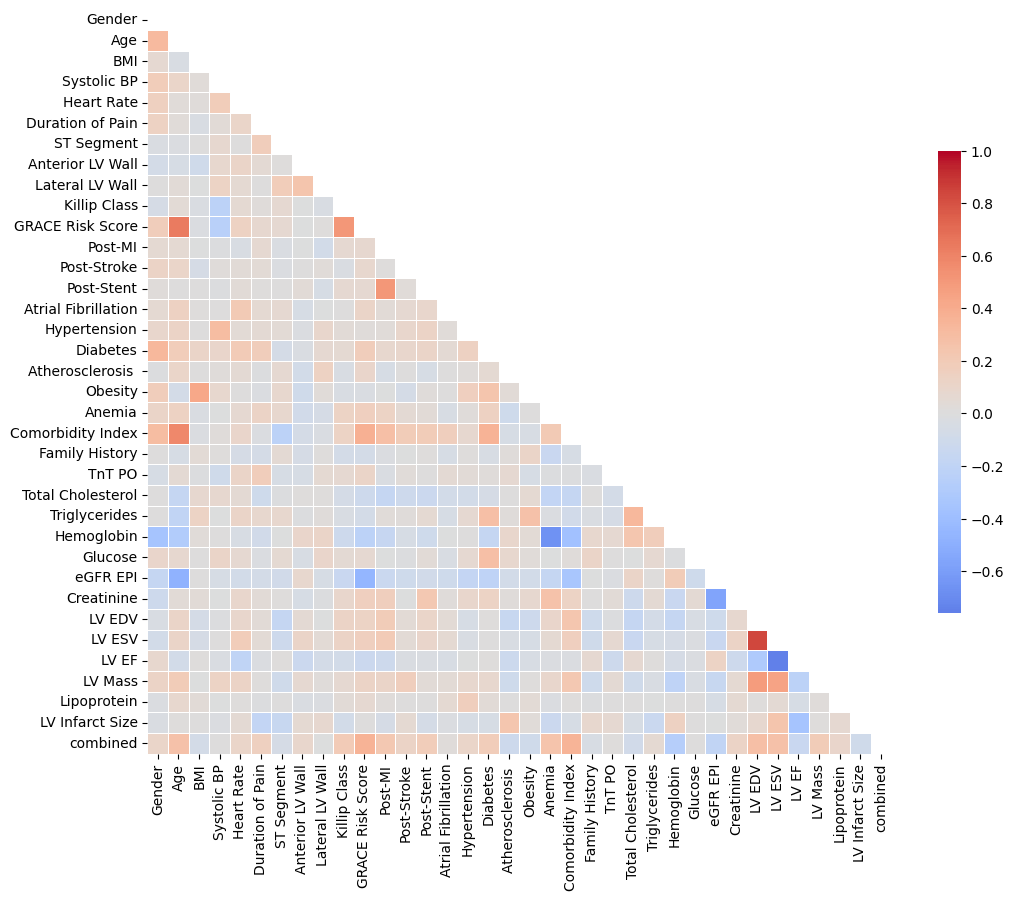

In [ ]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool),k=0)
f, ax = plt.subplots(figsize=(12,12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, vmax=1, center=0,cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=False)

### Pairplots

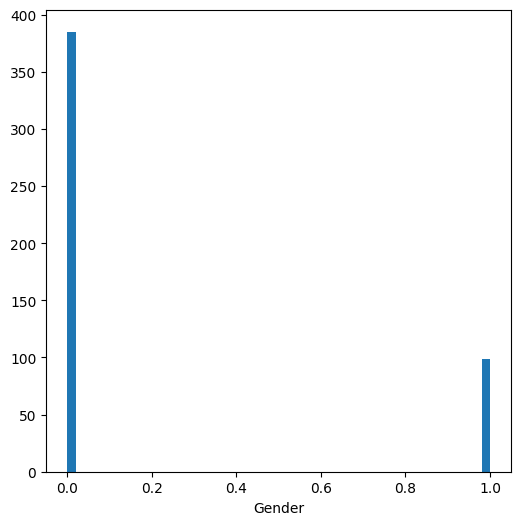

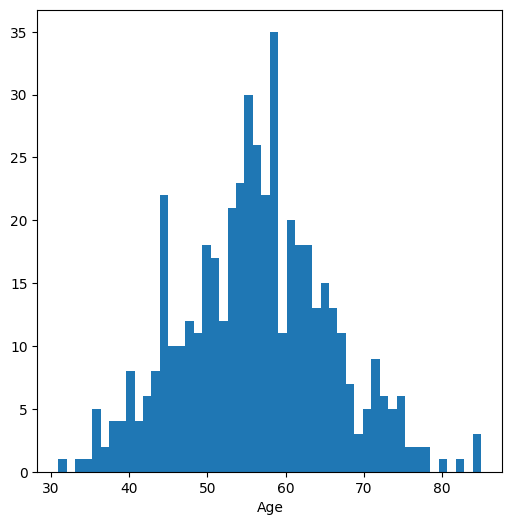

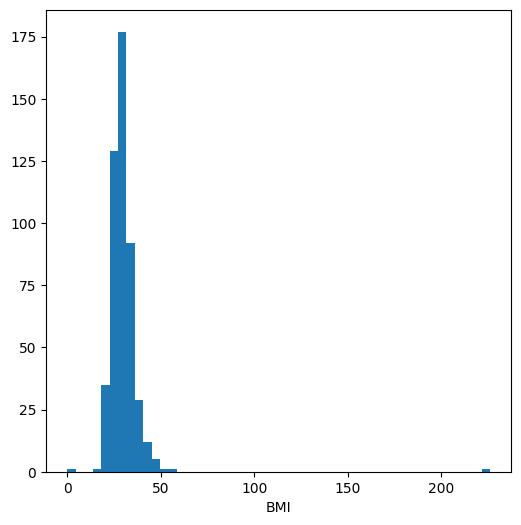

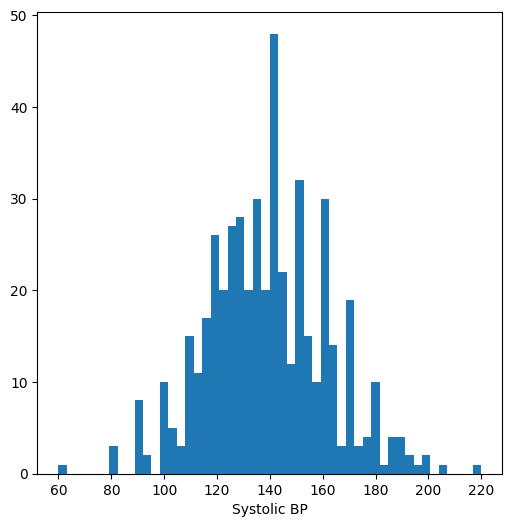

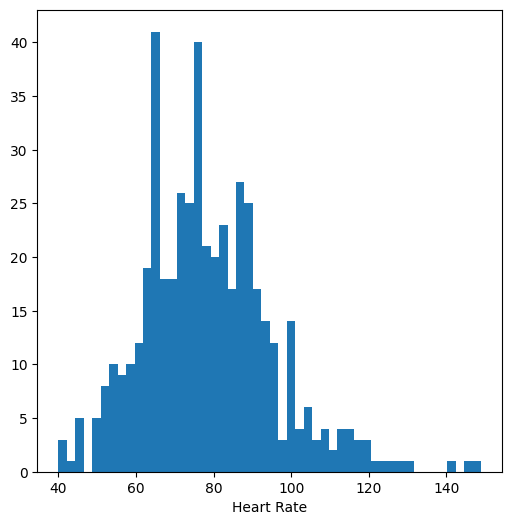

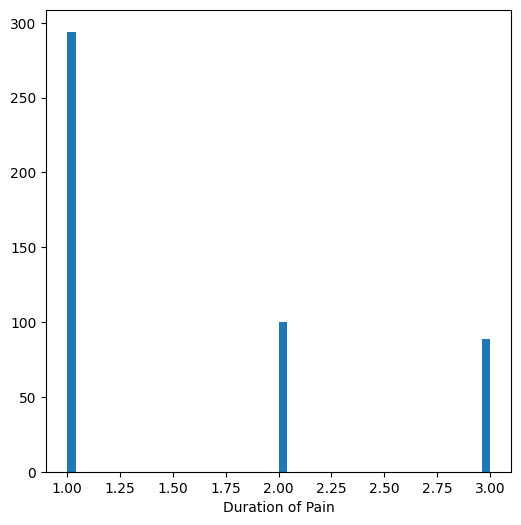

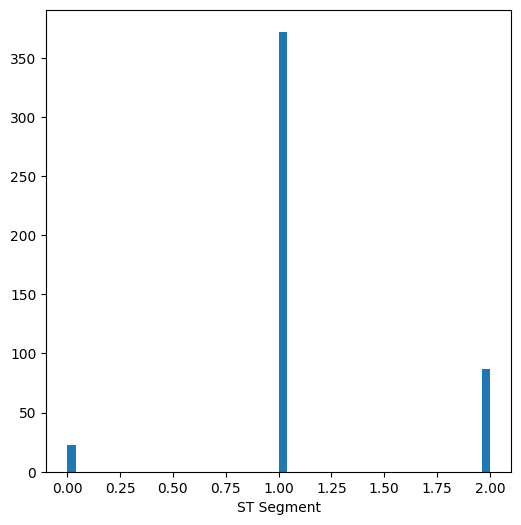

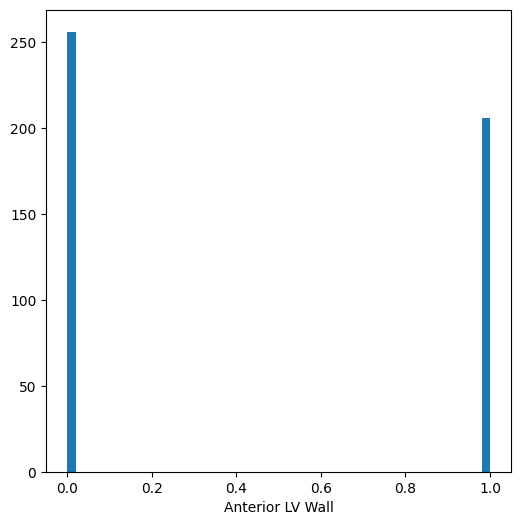

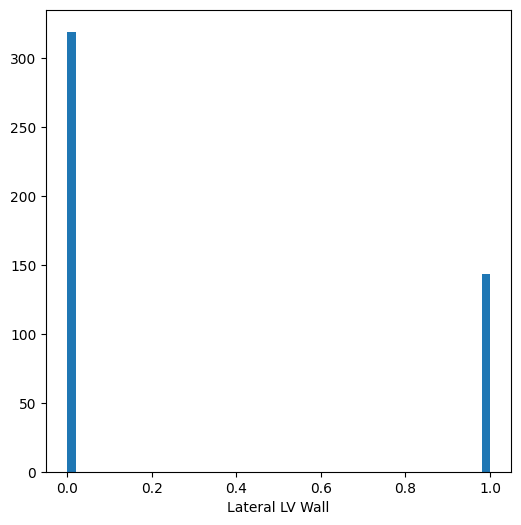

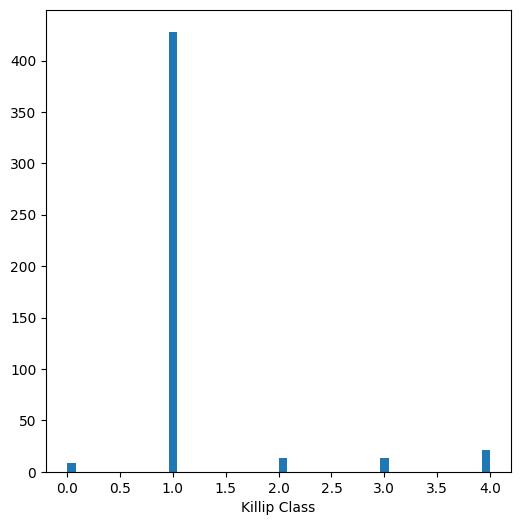

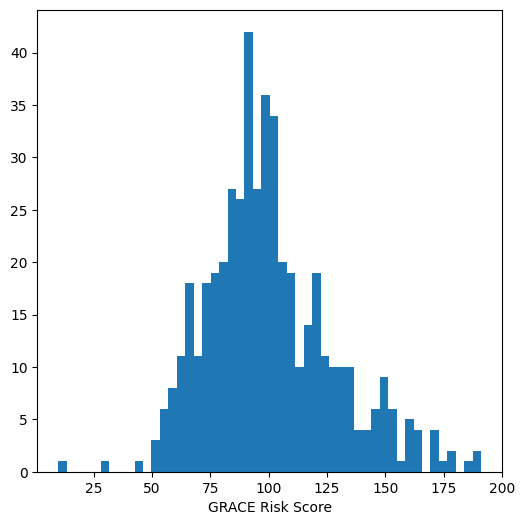

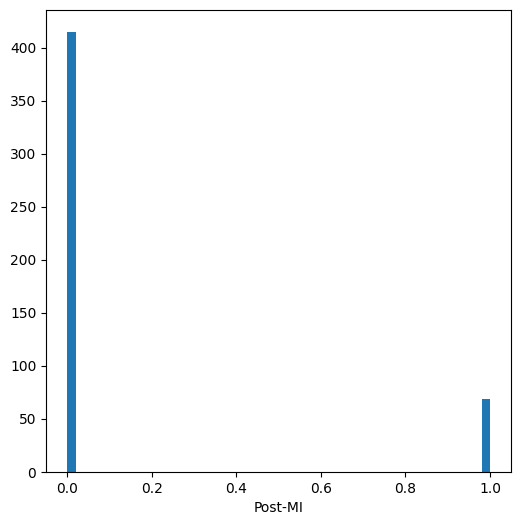

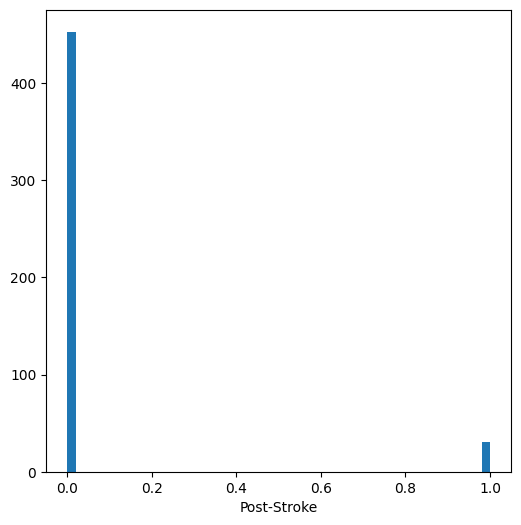

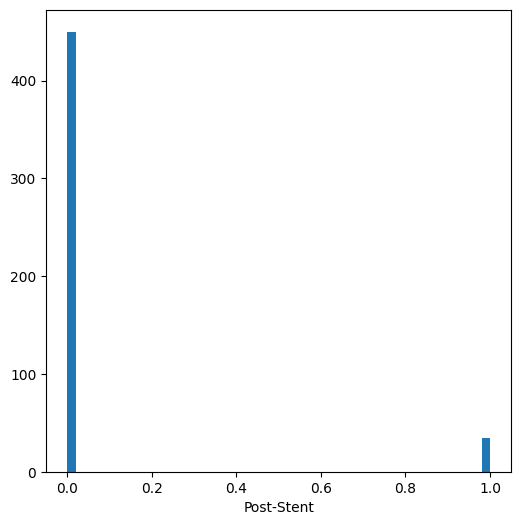

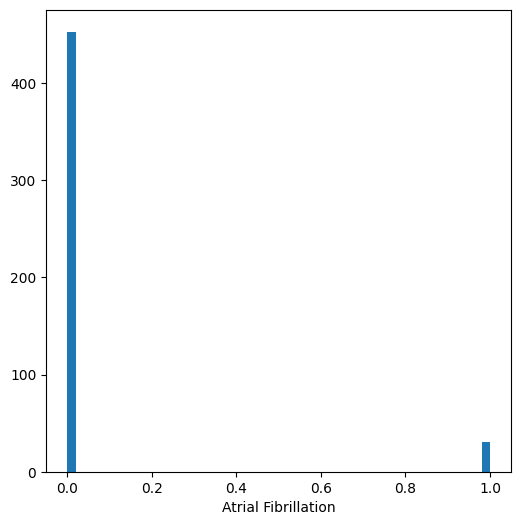

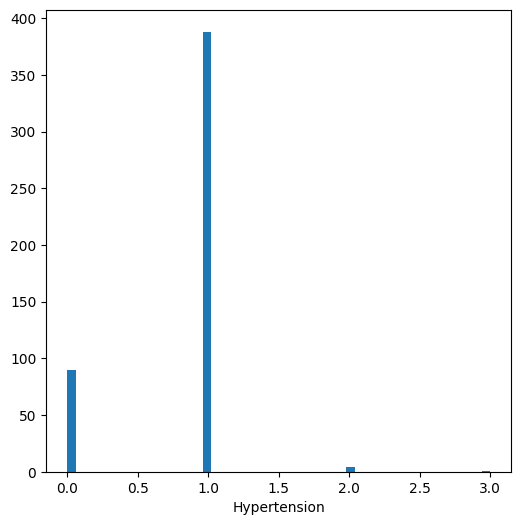

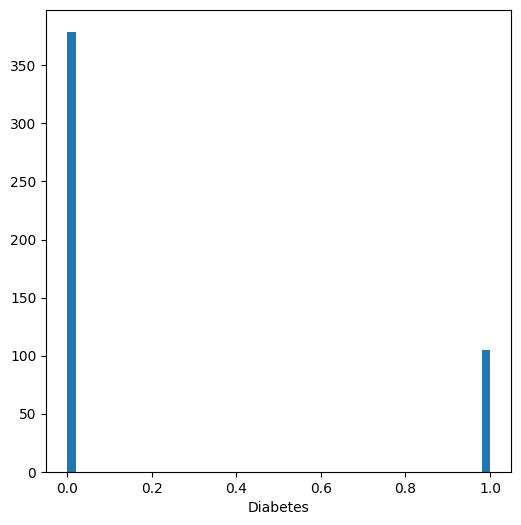

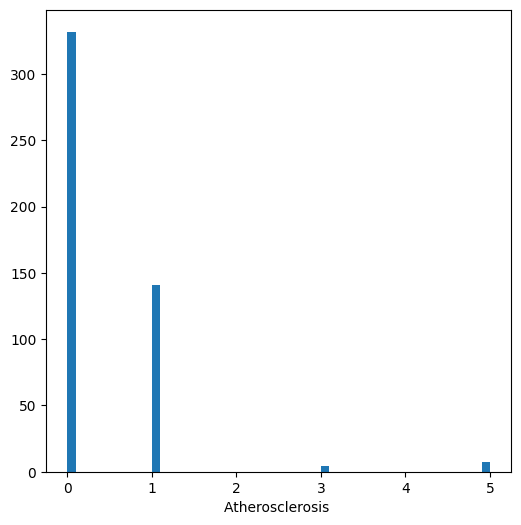

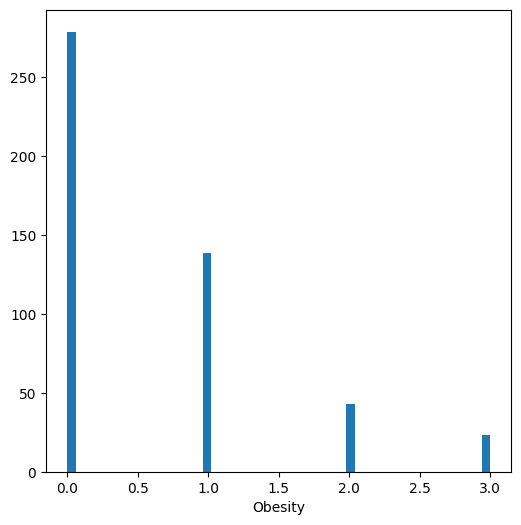

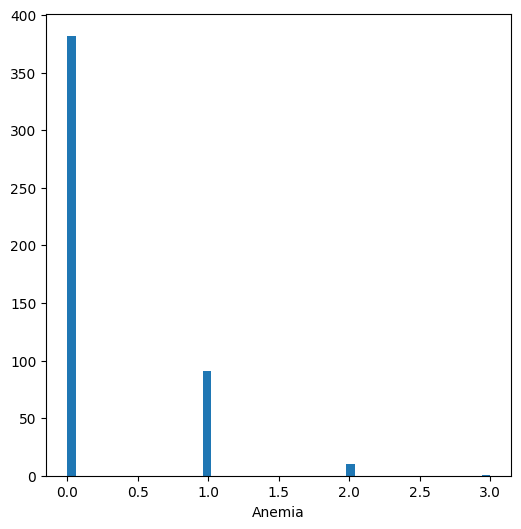

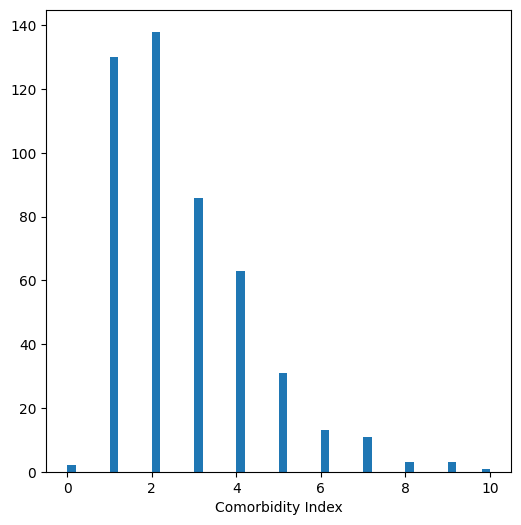

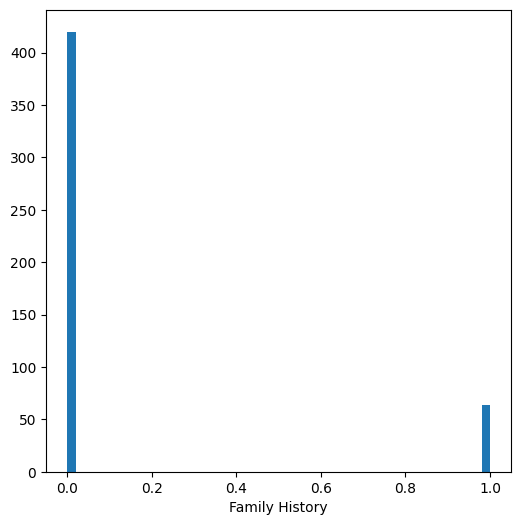

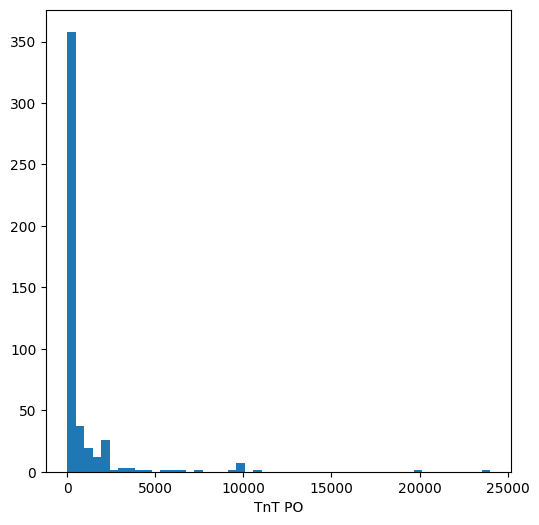

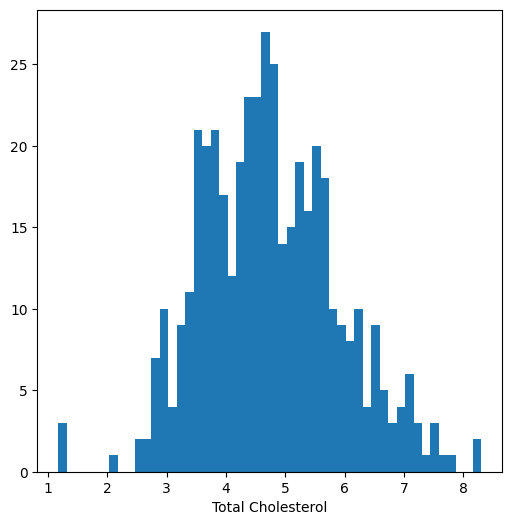

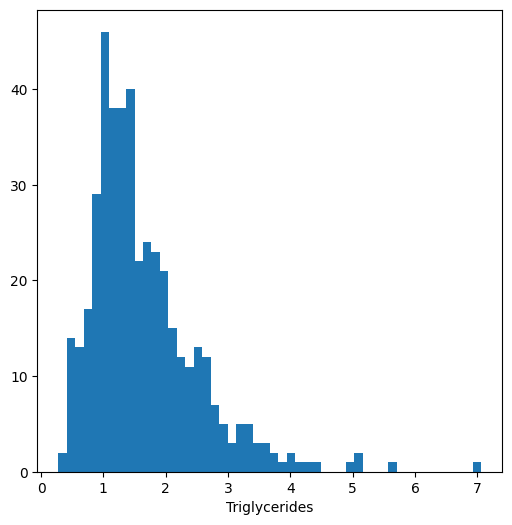

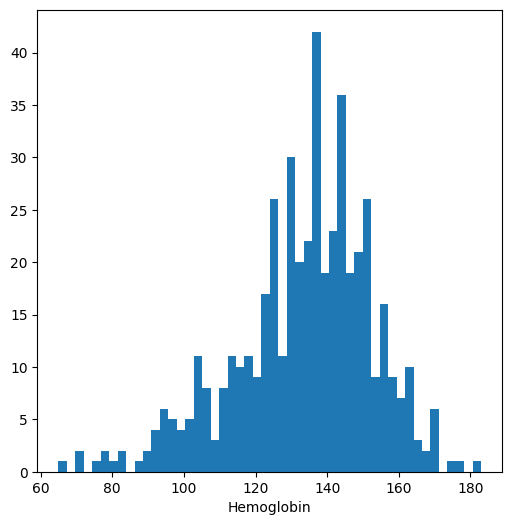

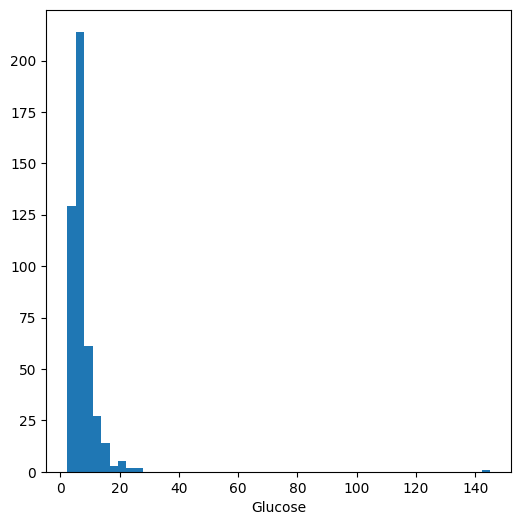

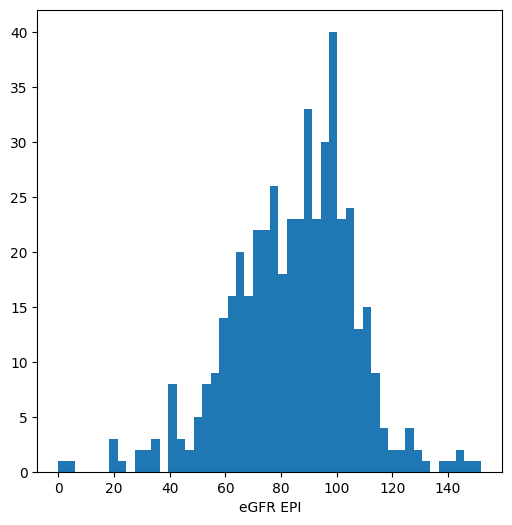

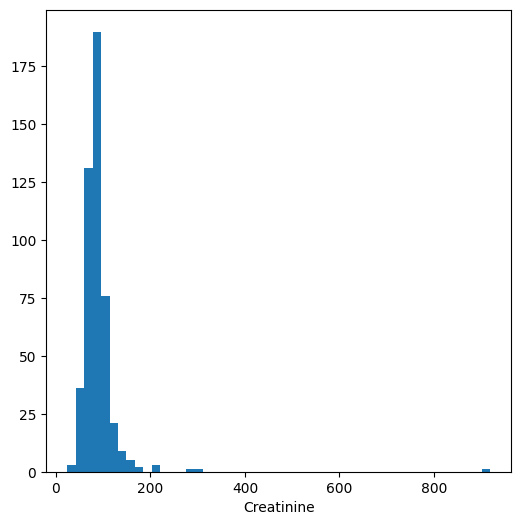

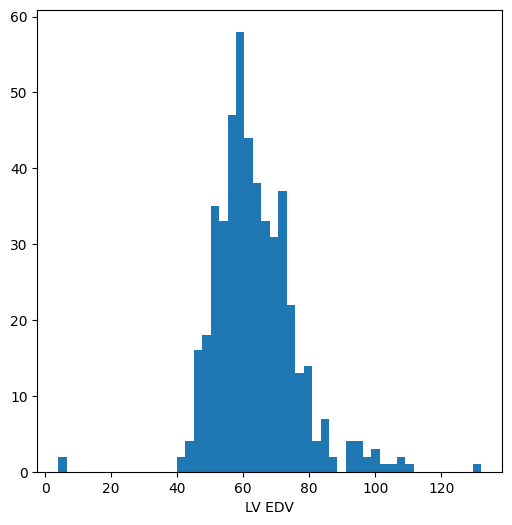

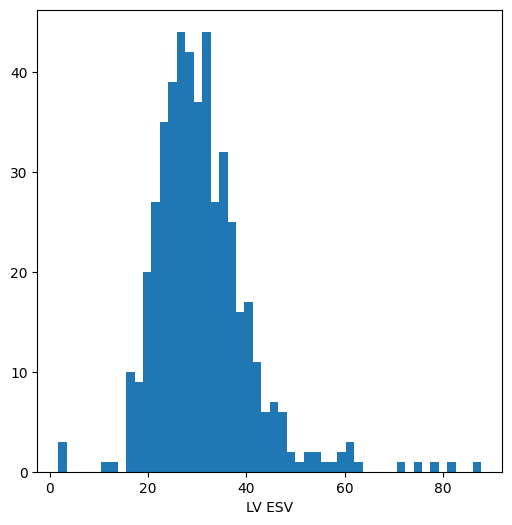

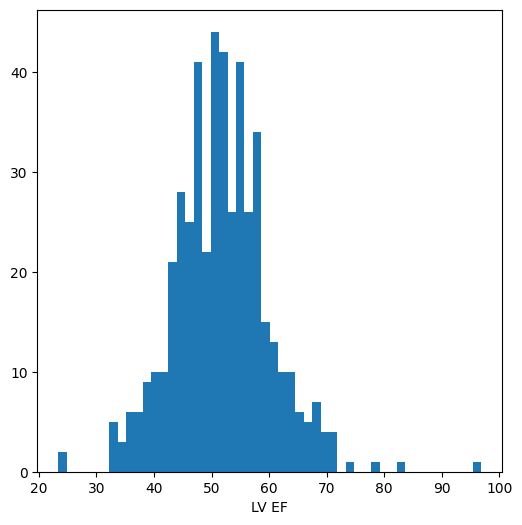

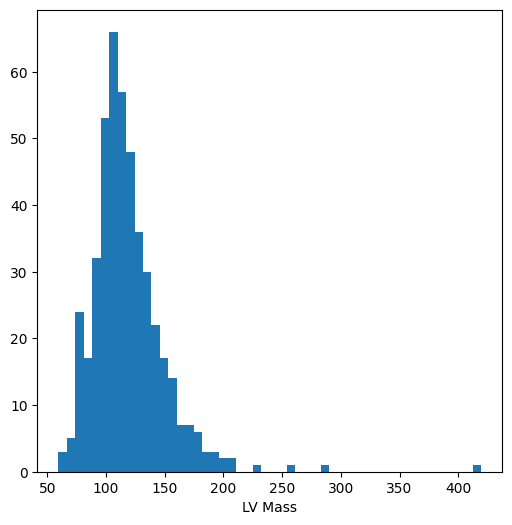

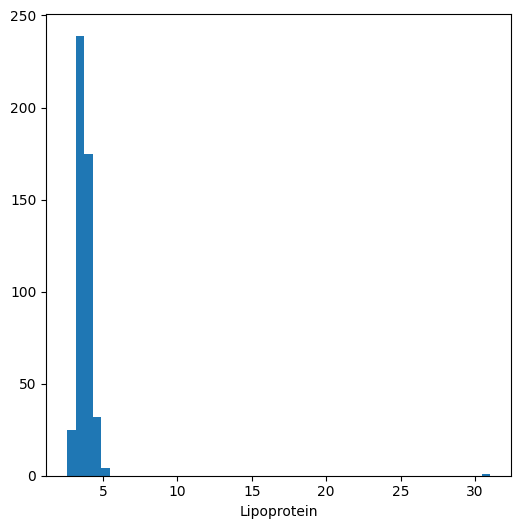

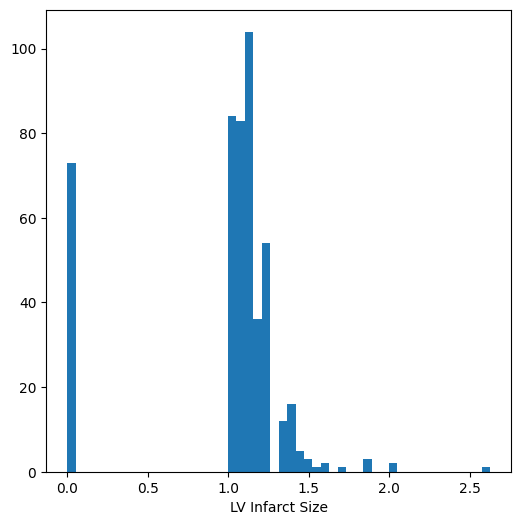

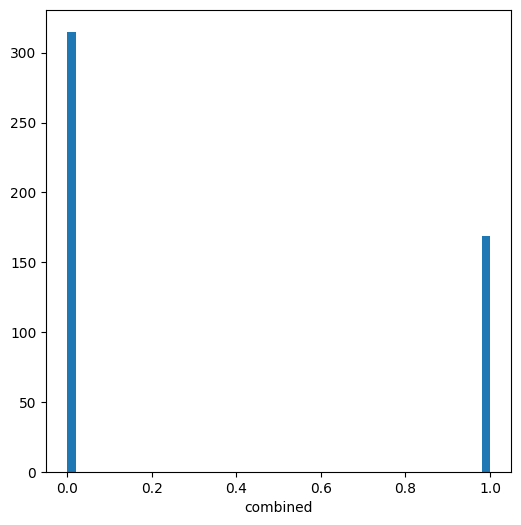

In [ ]:
plt.rcParams["figure.figsize"] = [6,6]  #set the graph to a smaller size
for i in range(0,36) :
    col_name = data.columns[i]  # get the column name to identify the graph
    x=data[col_name]
    plt.xlabel(col_name)         # The column name will be the x-label ( just to identify )
    k=plt.hist(x,bins=50)       # Change the right number of bins to get it more/less granular
    plt.show()

### Variance Inflation Factor

In [ ]:
data.dropna().shape

(372, 36)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Drop rows with missing values
vif_data = data.dropna()


# Create the predictor variables and the target variable
X = vif_data.drop('combined', axis=1)  # Replace 'target_variable' with the actual name of your target variable column
y = vif_data['combined']  # Replace 'target_variable' with the actual name of your target variable column

# Perform logistic regression with regularization
logistic_model = LogisticRegression()  # Adjust C as needed
logistic_model.fit(X, y)

# Create a new dataframe to store the coefficients
coefficients = pd.DataFrame(logistic_model.coef_.T, columns=['Coefficient'], index=X.columns)

# Calculate the VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data['Variables'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Merge the coefficients and VIF dataframes
vif_data = pd.merge(vif_data, coefficients, left_on='Variables', right_index=True)

# Display the VIF and coefficient dataframe
print(vif_data)

              Variables      VIF  Coefficient
0                Gender    2.385   -2.113e-03
1                   Age  123.790   -1.991e-02
2                   BMI    9.558   -5.510e-02
3           Systolic BP   67.301    8.009e-03
4            Heart Rate   31.327    2.212e-03
5      Duration of Pain    6.272    9.812e-03
6            ST Segment    8.819   -7.864e-03
7      Anterior LV Wall    2.097    5.938e-03
8       Lateral LV Wall    1.738    9.154e-05
9          Killip Class    6.694    9.567e-04
10     GRACE Risk Score   46.623    3.247e-02
11              Post-MI    1.839    8.635e-03
12          Post-Stroke    1.240    1.828e-03
13           Post-Stent    1.539    4.121e-03
14  Atrial Fibrillation    1.230   -5.074e-04
15         Hypertension    6.701    4.634e-03
16             Diabetes    2.169    5.274e-03
17     Atherosclerosis     1.590   -1.886e-02
18              Obesity    2.364   -6.656e-03
19               Anemia    2.373    5.991e-03
20    Comorbidity Index    8.636  

In [ ]:
vif_data[vif_data['VIF'] > 10]

,Variables,VIF,Coefficient
1,Age,123.790,-0.020
3,Systolic BP,67.301,0.008
4,Heart Rate,31.327,0.002
10,GRACE Risk Score,46.623,0.032
23,Total Cholesterol,27.143,0.002
25,Hemoglobin,111.935,-0.020
27,eGFR EPI,58.640,-0.010
28,Creatinine,39.462,-0.008
29,LV EDV,552.007,0.034
30,LV ESV,416.271,0.005


In [ ]:
data.shape[1] - vif_data[vif_data['VIF'] > 10].shape[0]

23

<Axes: xlabel='VIF', ylabel='Variables'>

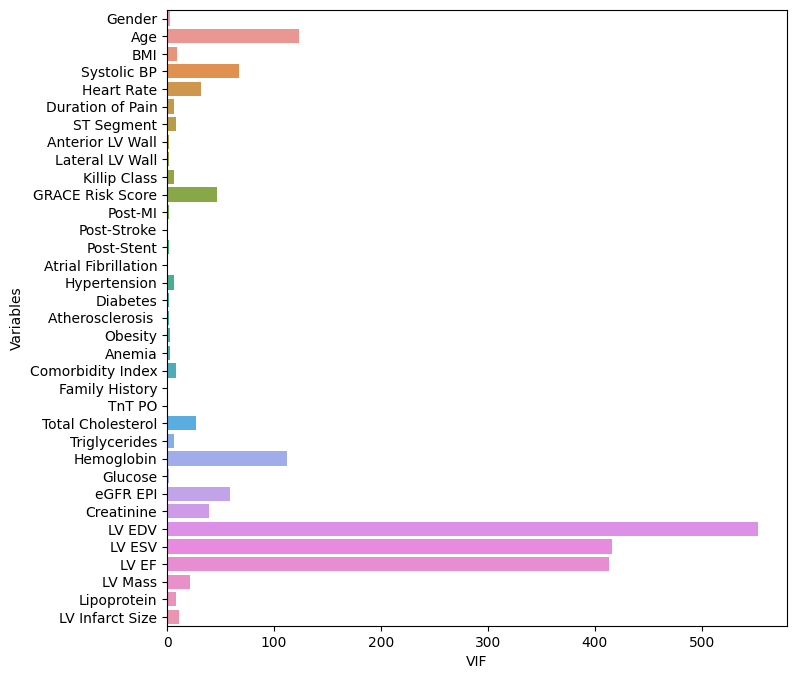

In [ ]:
f, ax = plt.subplots(figsize=(8,8))
sns.barplot(vif_data,y = 'Variables', x = 'VIF')

## Compare different imputation techniques

In [ ]:
def mice_impute_data(data_imputers_train,data_imputers_test,numerical = numerical,categorical = categorical,binary = binary):
    # Separate the data into numerical, categorical, and binary columns
    numerical_cols = numerical
    categorical_cols = categorical
    binary_cols = binary[:-1]


    nums = [data_imputers_train.columns.get_loc(numerical[x]) for x in range(len(numerical))]
    # Impute numerical columns using linear regression
    imputer_num = IterativeImputer(estimator=LinearRegression(),max_iter=100)
    data_imputers_train[numerical_cols] = imputer_num.fit_transform(data_imputers_train)[:,nums]
    data_imputers_test[numerical_cols] = imputer_num.transform(data_imputers_test)[:,nums]


    cat = [data_imputers_train.columns.get_loc((binary_cols + categorical_cols)[x]) for x in range(len((binary_cols + categorical_cols)))]
    # Impute binary columns using logistic regression
    imputer_bin = IterativeImputer(estimator=LogisticRegression(solver='liblinear'),max_iter=100,skip_complete=True)
    data_imputers_train[binary_cols + categorical_cols] = imputer_bin.fit_transform(data_imputers_train)[:,cat]
    data_imputers_test[binary_cols + categorical_cols] = imputer_bin.transform(data_imputers_test)[:,cat]

    return data_imputers_train,data_imputers_test

# Example usage
imputed_train, imputed_test = mice_impute_data(train.drop('combined',1).copy(), test.drop('combined',1).copy())
imputed_train.isna().sum().sum()
print(f"Total number of nan values: {imputed_train.isna().sum().sum()}")

Total number of nan values: 0


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency

def check_distribution_shift(df1, df2, numerical = numerical):
    """
    Check for distribution shift between two dataframes using the Kolmogorov-Smirnov test for each variable.

    Args:
        df1 (pandas.DataFrame): First dataframe.
        df2 (pandas.DataFrame): Second dataframe.

    Returns:
        dict: Dictionary with variable names as keys and True/False indicating distribution shift.
    """
    variables = set(df1.columns).intersection(df2.columns)
    shift_results = {}

    for variable in variables:
        data1 = df1[variable].values
        data2 = df2[variable].values
        stat, p_value = ks_2samp(data1, data2)

        # Check significance level (commonly set to 0.05)
        alpha = 0.01

        # If p-value is less than the significance level, distribution shift is detected
        if p_value < alpha:
            shift_results[variable] = True
        else:
            shift_results[variable] = False

    return shift_results


shift_results = check_distribution_shift(imputed_train.dropna(),train)

for variable, is_shift in shift_results.items():
  if is_shift == True:
    print(f"Distribution shift detected for {variable}: {is_shift}")

if True not in shift_results.values():
  print("Distribution shift not detected.")

Distribution shift not detected.


In [ ]:
def knn_impute_data(data_imputers_train,data_imputers_test,numerical = numerical,categorical = categorical,binary = binary):
    # Separate the data into numerical, categorical, and binary columns
    numerical_cols = numerical
    categorical_cols = categorical
    binary_cols = binary[:-1]
    not_num = categorical_cols + binary_cols

    # make a copy of X_train and X_test to avoid modifying original data
    X_train_processed = data_imputers_train.copy()
    X_test_processed = data_imputers_test.copy()

    # standardize numerical columns in X_train
    scaler = StandardScaler()
    X_train_processed[numerical_cols] = scaler.fit_transform(X_train_processed[numerical_cols])
    X_test_processed[numerical_cols] = scaler.transform(X_test_processed[numerical_cols])

    # impute missing values in X_train and X_test
    imputer = KNNImputer(n_neighbors=5)
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_processed), columns=X_train_processed.columns, index=X_train_processed.index)
    X_test_imputed = pd.DataFrame(imputer.transform(X_test_processed), columns=X_train_processed.columns, index=X_test_processed.index)
    X_train_new = pd.concat([X_train_imputed[numerical_cols], data_imputers_train[not_num]], axis=1)
    X_test_new = pd.concat([X_test_imputed[numerical_cols], data_imputers_test[not_num]], axis=1)

    # fill missing values in categorical columns with mode from X_train
    imputer = SimpleImputer(strategy='most_frequent')
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_processed), columns=X_train_processed.columns, index=X_train_processed.index)
    X_test_imputed = pd.DataFrame(imputer.transform(X_test_processed), columns=X_train_processed.columns, index=X_test_processed.index)
    X_train_new = pd.concat([X_train_new[numerical_cols], X_train_imputed[not_num]], axis=1)
    X_test_new = pd.concat([X_test_new[numerical_cols], X_test_imputed[not_num]], axis=1)


    return X_train_new, X_test_new

# Example usage
imputed_train, imputed_test = knn_impute_data(train.drop('combined',1).copy(), test.drop('combined',1).copy())
imputed_train.isna().sum().sum()
print(f"Total number of nan values: {imputed_train.isna().sum().sum()}")

shift_results = check_distribution_shift(imputed_train.dropna(),train)

for variable, is_shift in shift_results.items():
  if is_shift == True:
    print(f"Distribution shift detected for {variable}: {is_shift}")

if True not in shift_results.values():
  print("Distribution shift not detected.")

Total number of nan values: 0
Distribution shift detected for ЛП: True
Distribution shift detected for ИНЛС ЛЖ: True


In [ ]:
from plotly.figure_factory import create_distplot

In [ ]:
variables = [imputed_train['ИНЛС ЛЖ'], train.dropna()['ИНЛС ЛЖ']]
labels = ['Imputed', 'Original']
fig = create_distplot(variables, labels, show_hist=False)
fig.show()

In [ ]:
variables = [imputed_train['ЛП'], train.dropna()['ЛП']]
labels = ['Imputed', 'Original']
fig = create_distplot(variables, labels, show_hist=False)
fig.show()

In [ ]:
def simple_impute_data(data_imputers_train,data_imputers_test,numerical = numerical,categorical = categorical,binary = binary):
    # Separate the data into numerical, categorical, and binary columns
    numerical_cols = numerical
    categorical_cols = categorical
    binary_cols = binary[:-1]
    not_num = categorical_cols + binary_cols

    # make a copy of X_train and X_test to avoid modifying original data
    X_train_processed = data_imputers_train.copy()
    X_test_processed = data_imputers_test.copy()

    # standardize numerical columns in X_train
    scaler = StandardScaler()
    X_train_processed[numerical_cols] = scaler.fit_transform(X_train_processed[numerical_cols])
    X_test_processed[numerical_cols] = scaler.transform(X_test_processed[numerical_cols])

    # impute missing values in X_train and X_test
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_processed), columns=X_train_processed.columns, index=X_train_processed.index)
    X_test_imputed = pd.DataFrame(imputer.transform(X_test_processed), columns=X_train_processed.columns, index=X_test_processed.index)
    X_train_new = pd.concat([X_train_imputed[numerical_cols], data_imputers_train[not_num]], axis=1)
    X_test_new = pd.concat([X_test_imputed[numerical_cols], data_imputers_test[not_num]], axis=1)

    # fill missing values in categorical columns with mode from X_train
    imputer = SimpleImputer(strategy='most_frequent')
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_processed), columns=X_train_processed.columns, index=X_train_processed.index)
    X_test_imputed = pd.DataFrame(imputer.transform(X_test_processed), columns=X_train_processed.columns, index=X_test_processed.index)
    X_train_new = pd.concat([X_train_new[numerical_cols], X_train_imputed[not_num]], axis=1)
    X_test_new = pd.concat([X_test_new[numerical_cols], X_test_imputed[not_num]], axis=1)


    return X_train_new, X_test_new

# Example usage
imputed_train, imputed_test = knn_impute_data(train.drop('combined',1).copy(), test.drop('combined',1).copy())
imputed_train.isna().sum().sum()
print(f"Total number of nan values: {imputed_train.isna().sum().sum()}")

shift_results = check_distribution_shift(imputed_train.dropna(),train)

for variable, is_shift in shift_results.items():
  if is_shift == True:
    print(f"Distribution shift detected for {variable}: {is_shift}")

if True not in shift_results.values():
  print("Distribution shift not detected.")

Total number of nan values: 0
Distribution shift detected for ЛП: True
Distribution shift detected for ИНЛС ЛЖ: True
